In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.__version__)

2.13.0


In [3]:
image_data='/kaggle/input/emotion-recognition-dataset/dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Surprise
1,Angry
2,Neutral
3,Sad
4,Happy
5,Ahegao


In [4]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pan.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/kaggle/input/emotion-recognition-dataset/data...,Neutral
1,/kaggle/input/emotion-recognition-dataset/data...,Sad
2,/kaggle/input/emotion-recognition-dataset/data...,Neutral
3,/kaggle/input/emotion-recognition-dataset/data...,Neutral
4,/kaggle/input/emotion-recognition-dataset/data...,Sad
...,...,...
15448,/kaggle/input/emotion-recognition-dataset/data...,Happy
15449,/kaggle/input/emotion-recognition-dataset/data...,Neutral
15450,/kaggle/input/emotion-recognition-dataset/data...,Ahegao
15451,/kaggle/input/emotion-recognition-dataset/data...,Happy


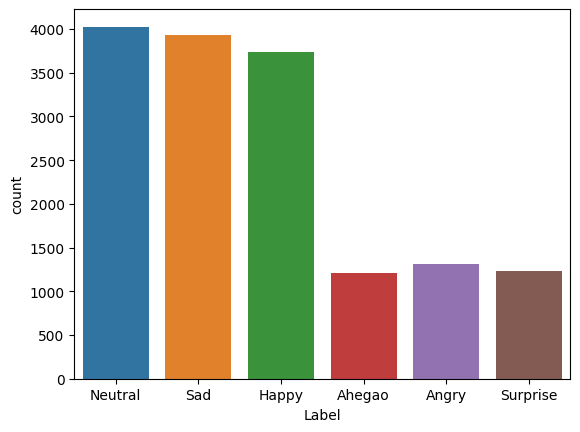

In [5]:
sns.countplot(x = dataframe["Label"])
plotter.xticks(rotation = 0);

In [6]:
train_data_dir =image_data
batch_size = 64
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 15453 files belonging to 6 classes.
Using 12363 files for training.
Found 15453 files belonging to 6 classes.
Using 3090 files for validation.


In [7]:
train_size = len(train)
val_size = len(validation)
total = train_size + val_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print('================================================')
print(f'Total:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		194	(79.84%)
validation samples count:	49	(20.16%)
Total:				243	(100.00%)


In [8]:
class_names=train.class_names
class_names

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

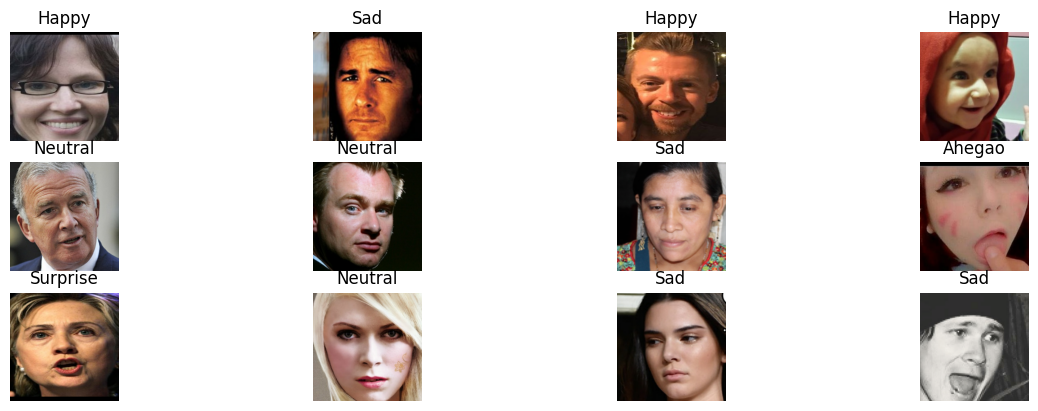

In [9]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(12, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
base_model = tf.keras.applications.EfficientNetV2M(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten()) 
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(6,activation=tf.nn.softmax))
keras_model.summary()

214201816/214201816 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Function  (None, 7, 7, 1280)        53150388  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 6)                 376326    
                                                                 
Total params: 53526714 (204.19 MB)
Trainable params: 376326 (1.44 MB)
Non-trainable params: 53150388 (202.75 MB)
_________________________________________________________________


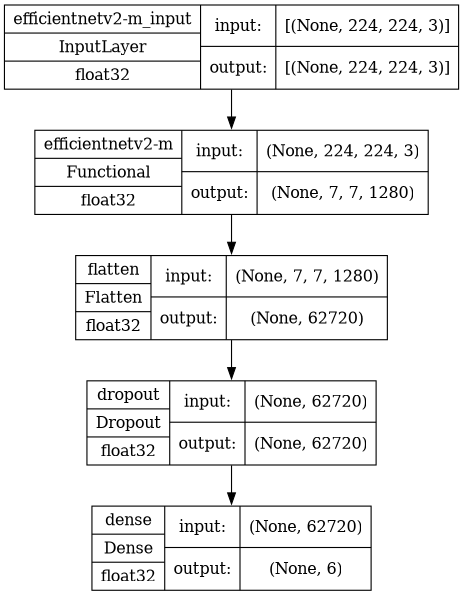

In [11]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [12]:
checkpoint = ModelCheckpoint('my_keras_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)
callbacks = [checkpoint, earlystopping, rlrop]

In [13]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [14]:
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=40,validation_data=validation,callbacks=callbacks)

Epoch 1/40


2024-06-19 04:35:53.426556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


194/194 [==============================] - ETA: 0s - loss: 2.1433 - accuracy: 0.5533
Epoch 1: val_accuracy improved from -inf to 0.70906, saving model to my_keras_model.h5
194/194 [==============================] - 101s 385ms/step - loss: 2.1433 - accuracy: 0.5533 - val_loss: 1.2551 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 2/40
194/194 [==============================] - ETA: 0s - loss: 1.7179 - accuracy: 0.6563
Epoch 2: val_accuracy improved from 0.70906 to 0.74693, saving model to my_keras_model.h5
194/194 [==============================] - 61s 306ms/step - loss: 1.7179 - accuracy: 0.6563 - val_loss: 1.1864 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 3/40
194/194 [==============================] - ETA: 0s - loss: 1.5388 - accuracy: 0.6991
Epoch 3: val_accuracy improved from 0.74693 to 0.80032, saving model to my_keras_model.h5
194/194 [==============================] - 61s 307ms/step - loss: 1.5388 - accuracy: 0.6991 - val_loss: 0.9000 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 4/40
194

In [15]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

49/49 [==============================] - 12s 214ms/step - loss: 0.7458 - accuracy: 0.9259
Test Loss = 0.7458394765853882
Test Accuracy = 0.9258899688720703


In [16]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy,lr
0,2.143343,0.553345,1.255065,0.709062,0.0010
1,1.717868,0.656313,1.186398,0.746926,0.0010
2,1.538791,0.699102,0.899997,0.800324,0.0010
3,1.566445,0.714794,1.039590,0.790615,0.0010
4,1.402420,0.744965,0.917250,0.817152,0.0010
5,1.412693,0.753781,0.903337,0.831392,0.0010
6,1.399423,0.767370,0.866441,0.846926,0.0010
7,1.326887,0.774488,1.108447,0.820065,0.0010
8,1.357092,0.784276,0.841523,0.843689,0.0010
9,1.365936,0.789533,0.799745,0.856958,0.0010


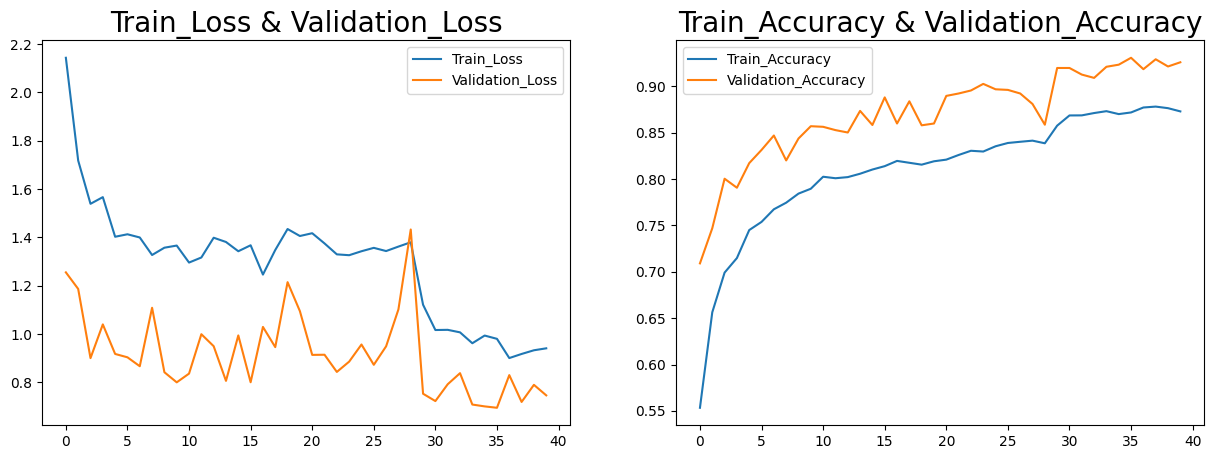

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()